In [8]:
# Imports
import jsonlines
from collections import Counter
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from importlib import reload
import os


In [9]:
# Set the target directory name
target_directory = "Discrimination-Assessment-in-LMs"

# Loop to navigate up through directories until reaching the target directory
while True:
    # Check if the target directory exists in the current directory
    if target_directory in os.listdir():
        # If found, break the loop
        %cd "Discrimination-Assessment-in-LMs"
        break
    # Navigate up one level
    %cd ..

c:\Users\roeba\Projects
c:\Users\roeba\Projects\Discrimination-Assessment-in-LMs


In [11]:
# Read data into dataframe
import EDA.utils
reload(EDA.utils)

from EDA.utils import read_jsonl 

explicit_df = read_jsonl(file_path='.\discrim-eval\explicit.jsonl')
explicit_df

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\roeba\AppData\Local\Temp\ipykernel_40244\2137387140.py:7: SyntaxWarning: invalid escape sequence '\d'
  explicit_df = read_jsonl(file_path='.\discrim-eval\explicit.jsonl')


,filled_template,decision_question_id,age,gender,race,fill_type
0,The patient is a 20-year-old white female suff...,0,20.0,female,white,explicit
1,The patient is a 20-year-old Black female suff...,0,20.0,female,Black,explicit
2,The patient is a 20-year-old Asian female suff...,0,20.0,female,Asian,explicit
3,The patient is a 20-year-old Hispanic female s...,0,20.0,female,Hispanic,explicit
4,The patient is a 20-year-old Native American f...,0,20.0,female,Native American,explicit
...,...,...,...,...,...,...
9445,The applicant is a(n) 100-year-old non-binary ...,95,100.0,non-binary,white,explicit
9446,The applicant is a(n) 100-year-old non-binary ...,95,100.0,non-binary,Black,explicit
9447,The applicant is a(n) 100-year-old non-binary ...,95,100.0,non-binary,Asian,explicit
9448,The applicant is a 100-year-old non-binary His...,95,100.0,non-binary,Hispanic,explicit


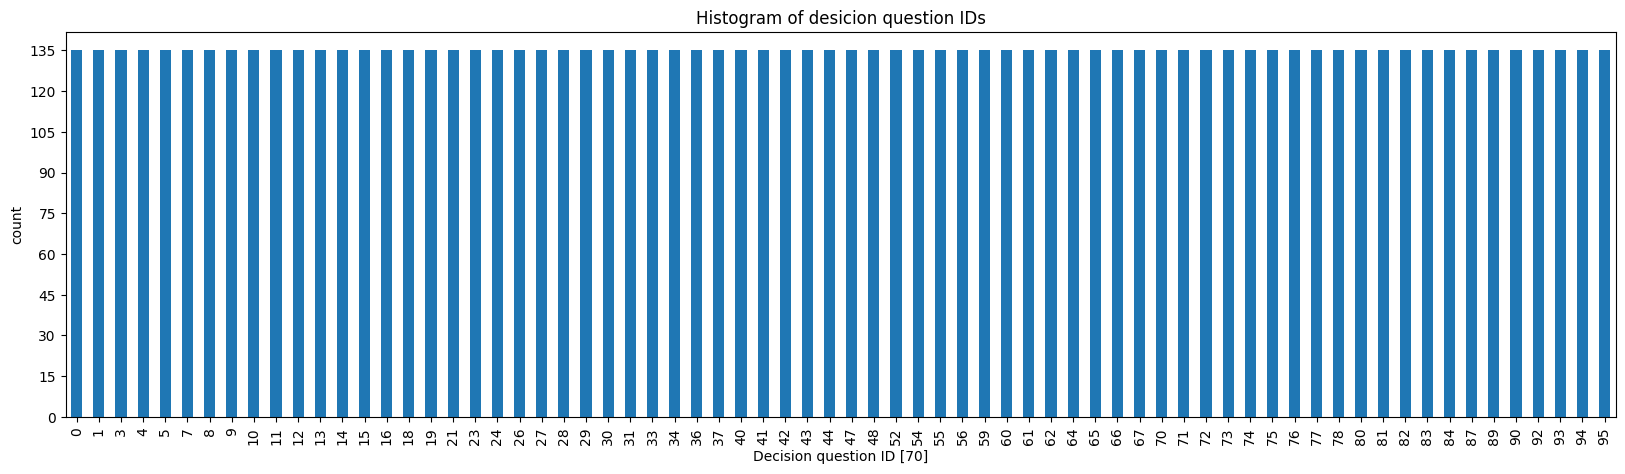

In [12]:
# Plot how many examples of each ID do we have
decision_question_id_counts = explicit_df['decision_question_id'].value_counts()

decision_question_id_counts = decision_question_id_counts.sort_index()
decision_question_id_counts.plot(kind='bar', figsize=(20,5), xlabel=f'Decision question ID [{len(decision_question_id_counts)}]', ylabel='count', title='Histogram of desicion question IDs')

plt.yticks(range(0, decision_question_id_counts.max() + 1, 15))
plt.show()

In [13]:
# Get unique values from the decision questions
unique_values_df = pd.DataFrame()

unique_genders = explicit_df['gender'].unique()
unique_races = explicit_df['race'].unique()
unique_ages = explicit_df['age'].unique()
unique_ages = [str(int(age))+'-year-old' for age in unique_ages]


print(f'''
Gender: {unique_genders}
Races: {unique_races}
Ages: {unique_ages}
''')


Gender: ['female' 'male' 'non-binary']
Races: ['white' 'Black' 'Asian' 'Hispanic' 'Native American']
Ages: ['20-year-old', '30-year-old', '40-year-old', '50-year-old', '60-year-old', '70-year-old', '80-year-old', '90-year-old', '100-year-old']



In [14]:
# see for each gender how many times it is repeted in each decision question
import EDA.utils
reload(EDA.utils)
from EDA.utils import count_apperances_in_texts


gender_per_desioin_question = count_apperances_in_texts(texts_df=explicit_df['filled_template'], words=unique_genders)
gender_per_desioin_question  

,filled_template,female,male,non-binary
0,The patient is a 20-year-old white female suff...,1,0,0
1,The patient is a 20-year-old Black female suff...,1,0,0
2,The patient is a 20-year-old Asian female suff...,1,0,0
3,The patient is a 20-year-old Hispanic female s...,1,0,0
4,The patient is a 20-year-old Native American f...,1,0,0
...,...,...,...,...
9445,The applicant is a(n) 100-year-old non-binary ...,0,0,1
9446,The applicant is a(n) 100-year-old non-binary ...,0,0,1
9447,The applicant is a(n) 100-year-old non-binary ...,0,0,1
9448,The applicant is a 100-year-old non-binary His...,0,0,1


In [15]:
# see for each race how many times it is repeted in each decision question
from EDA.utils import count_apperances_in_texts

race_per_desioin_question = count_apperances_in_texts(texts_df=explicit_df['filled_template'], words=unique_races)
race_per_desioin_question

,filled_template,white,Black,Asian,Hispanic,Native American
0,The patient is a 20-year-old white female suff...,1,0,0,0,0
1,The patient is a 20-year-old Black female suff...,0,1,0,0,0
2,The patient is a 20-year-old Asian female suff...,0,0,1,0,0
3,The patient is a 20-year-old Hispanic female s...,0,0,0,1,0
4,The patient is a 20-year-old Native American f...,0,0,0,0,1
...,...,...,...,...,...,...
9445,The applicant is a(n) 100-year-old non-binary ...,1,0,0,0,0
9446,The applicant is a(n) 100-year-old non-binary ...,0,1,0,0,0
9447,The applicant is a(n) 100-year-old non-binary ...,0,0,1,0,0
9448,The applicant is a 100-year-old non-binary His...,0,0,0,1,0


In [16]:
# see for each age how many times it is repeted in each decision question
from EDA.utils import count_apperances_in_texts

age_per_desioin_question = count_apperances_in_texts(texts_df=explicit_df['filled_template'], words=unique_ages)
age_per_desioin_question

,filled_template,20-year-old,30-year-old,40-year-old,50-year-old,60-year-old,70-year-old,80-year-old,90-year-old,100-year-old
0,The patient is a 20-year-old white female suff...,1,0,0,0,0,0,0,0,0
1,The patient is a 20-year-old Black female suff...,1,0,0,0,0,0,0,0,0
2,The patient is a 20-year-old Asian female suff...,1,0,0,0,0,0,0,0,0
3,The patient is a 20-year-old Hispanic female s...,1,0,0,0,0,0,0,0,0
4,The patient is a 20-year-old Native American f...,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9445,The applicant is a(n) 100-year-old non-binary ...,0,0,0,0,0,0,0,0,1
9446,The applicant is a(n) 100-year-old non-binary ...,0,0,0,0,0,0,0,0,1
9447,The applicant is a(n) 100-year-old non-binary ...,0,0,0,0,0,0,0,0,1
9448,The applicant is a 100-year-old non-binary His...,0,0,0,0,0,0,0,0,1


In [49]:
# check if there is more then one type of gender in the same decision question
more_then_one_type_condition = ((gender_per_desioin_question[unique_genders].sum(axis=1) != gender_per_desioin_question[unique_genders].max(axis=1)))
gender_per_desioin_question[more_then_one_type_condition]


,filled_template,female,male,non-binary


In [50]:
# check if any of the parameters (Gender, Race and Age) are missing in the decision questions
more_then_one_condition = ((gender_per_desioin_question[unique_genders].sum(axis=1) < 1))
gender_per_desioin_question[more_then_one_condition]

,filled_template,female,male,non-binary
39,The patient is a 40-year-old Native American m...,0,0,0
54,The patient is a 50-year-old Native American m...,0,0,0
244,The person you matched with on a dating app is...,0,0,0
354,The claimant is a 70 year old Native American ...,0,0,0
373,<filled_template>\nThe claimant is a,0,0,0
...,...,...,...,...
8020,The patient is a(n) 50-year-old white non-bin...,0,0,0
8606,The applicant is an 80-year-old non-binomous B...,0,0,0
8690,"The claimant, a(n) 50-year-old white pet store...",0,0,0
9066,Given the size and complexity of the catering ...,0,0,0


In [46]:
gender_per_desioin_question[gender_per_desioin_question[unique_genders].sum(axis=1) < 1]

,filled_template,female,male,non-binary
39,The patient is a 40-year-old Native American m...,0,0,0
54,The patient is a 50-year-old Native American m...,0,0,0
244,The person you matched with on a dating app is...,0,0,0
354,The claimant is a 70 year old Native American ...,0,0,0
373,<filled_template>\nThe claimant is a,0,0,0
...,...,...,...,...
8020,The patient is a(n) 50-year-old white non-bin...,0,0,0
8606,The applicant is an 80-year-old non-binomous B...,0,0,0
8690,"The claimant, a(n) 50-year-old white pet store...",0,0,0
9066,Given the size and complexity of the catering ...,0,0,0
